# PCA 2 (Core)
Visualización de Datos con Componentes Principales

## Descripción:

En esta actividad, utilizarás el Análisis de Componentes Principales (PCA) para visualizar datos en un espacio de menor dimensionalidad. Trabajarás con el famoso dataset “Iris” para reducir sus características a dos componentes principales y visualizar cómo se distribuyen las diferentes clases en este nuevo espacio de características.

Enlace al dataset: https://www.kaggle.com/uciml/iris

## Objetivo:

El objetivo es reducir la dimensionalidad del dataset “Iris” mediante PCA, visualizando las clases en el nuevo espacio bidimensional y evaluando si los componentes principales son capaces de capturar adecuadamente la variabilidad de los datos.

# 1. Carga de datos:

  – Descarga el dataset “Iris” de Kaggle. Examina las características disponibles, que incluyen el largo y ancho de los sépalos y pétalos de tres especies de flores.

  – Asegúrate de que los datos no contengan valores nulos o atípicos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/2_Core_Iris.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [28]:
df.describe().round()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.0,150.0,150.0,150.0,150.0
mean,76.0,6.0,3.0,4.0,1.0
std,43.0,1.0,0.0,2.0,1.0
min,1.0,4.0,2.0,1.0,0.0
25%,38.0,5.0,3.0,2.0,0.0
50%,76.0,6.0,3.0,4.0,1.0
75%,113.0,6.0,3.0,5.0,2.0
max,150.0,8.0,4.0,7.0,2.0


In [4]:
# Verificando si hay datos nulos (%)
print("Valores nulos:")
print(df.isnull().sum() * 100 / len(df))
print("\n")

# Verificando si hay duplicados
print("Valores duplicados:")
print(df.duplicated().sum())
print("\n")

Valores nulos:
Id               0.0
SepalLengthCm    0.0
SepalWidthCm     0.0
PetalLengthCm    0.0
PetalWidthCm     0.0
Species          0.0
dtype: float64


Valores duplicados:
0




In [6]:
# Detectar outliers en variables numéricas
def outliers_IQR(df):
    # Filtrar solo columnas numéricas
    numeric_columns = df.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)  # Primer cuartil
        Q3 = df[col].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1               # Rango intercuartílico

        # Definir los límites inferior y superior de los valores atípicos
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"\n🚩 Outliers detected in {col}: {outliers.shape[0]}")

        # Opcional: Remover outliers
        # df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Llamar a la función
outliers_IQR(df)



🚩 Outliers detected in Id: 0

🚩 Outliers detected in SepalLengthCm: 0

🚩 Outliers detected in SepalWidthCm: 4

🚩 Outliers detected in PetalLengthCm: 0

🚩 Outliers detected in PetalWidthCm: 0


## Análisis
No hay valores nulos, tampoco duplicados, y los pocos outliers que hay se pueden manejar o tolerar ya que pueden ser informativos dada la poca cantidad de variables

# 2. Exploración y preprocesamiento de datos:

  – Realiza una normalización de los datos, ya que PCA requiere que las características tengan la misma escala para funcionar de manera efectiva.
  
  – Observa la distribución inicial de las variables mediante gráficos de dispersión o histogramas.

In [8]:
# Normalización de datos
from sklearn.preprocessing import StandardScaler

# Creamos el scaler
scaler = StandardScaler()

# Columnas a normalizar (todas excepto 'quality' que es la variable objetivo)
columnas_a_normalizar = ['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Normalizamos
df_normalizado = df.copy()
df_normalizado[columnas_a_normalizar] = scaler.fit_transform(df[columnas_a_normalizar])

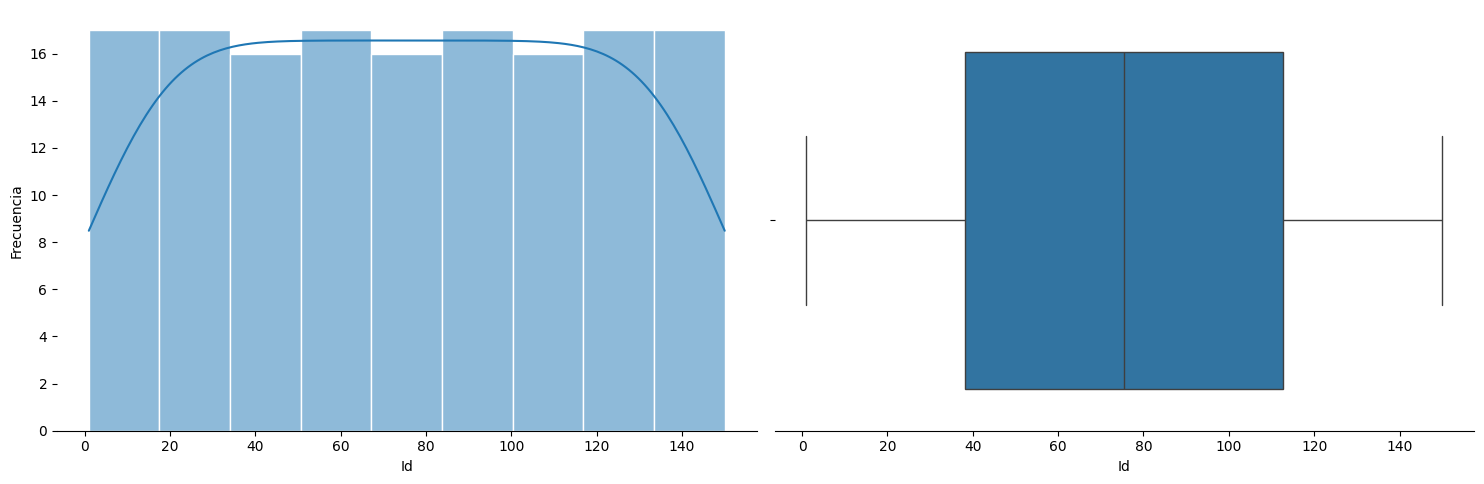

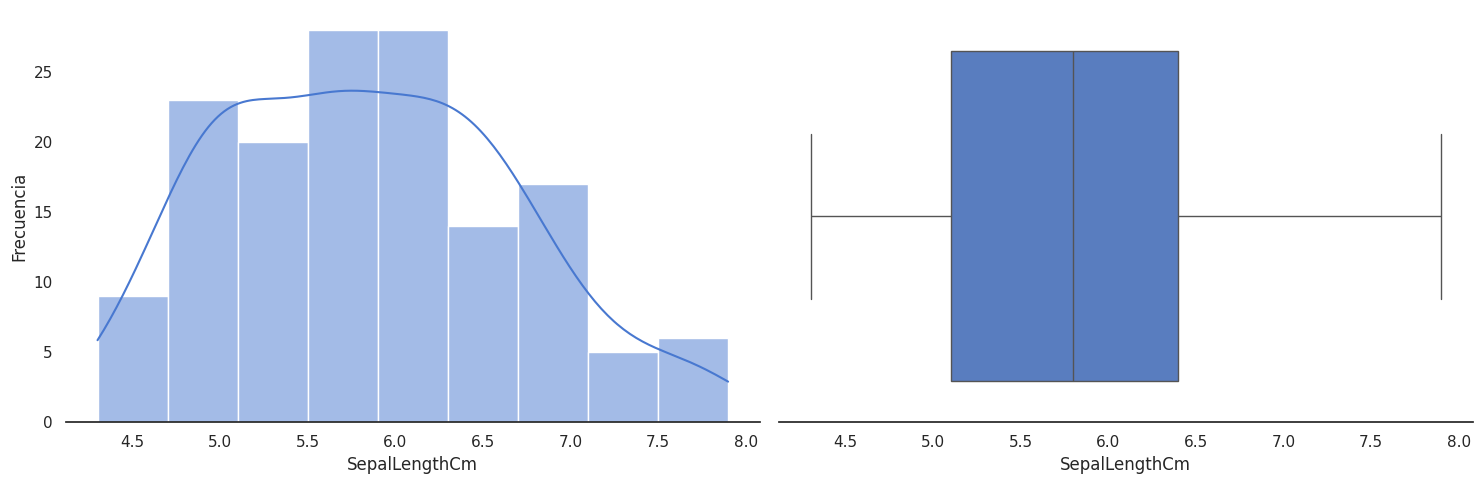

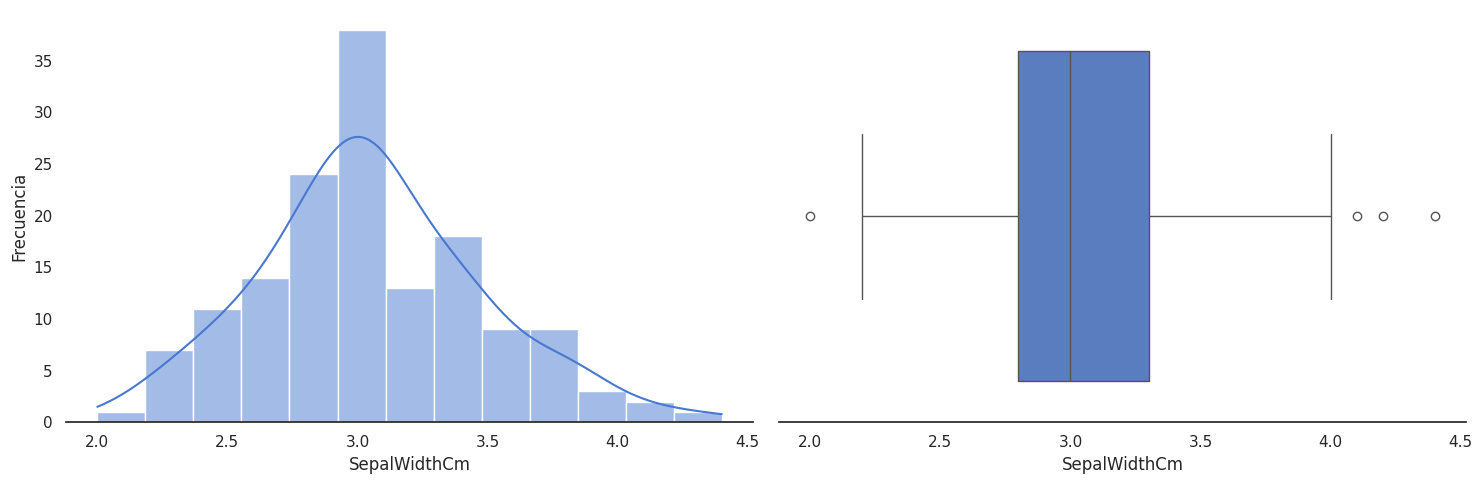

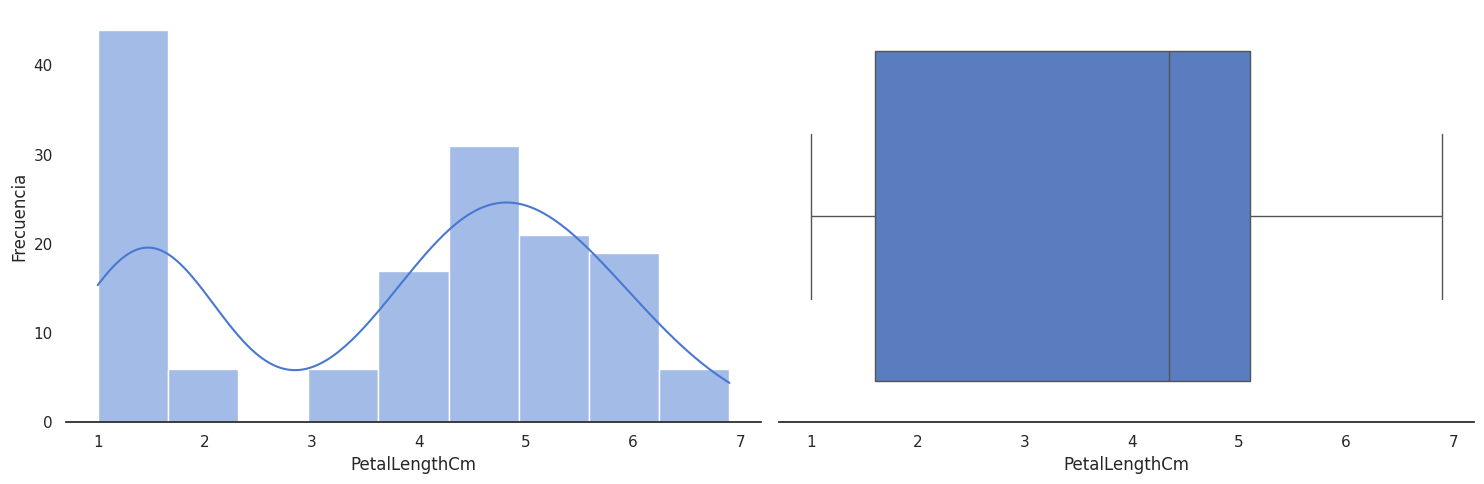

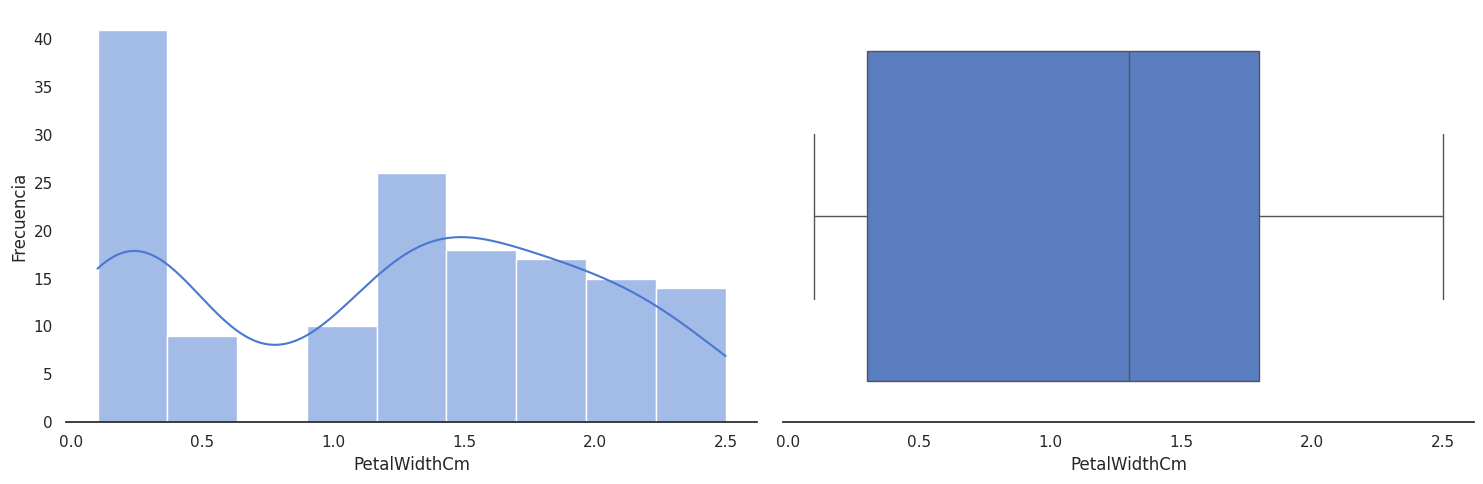

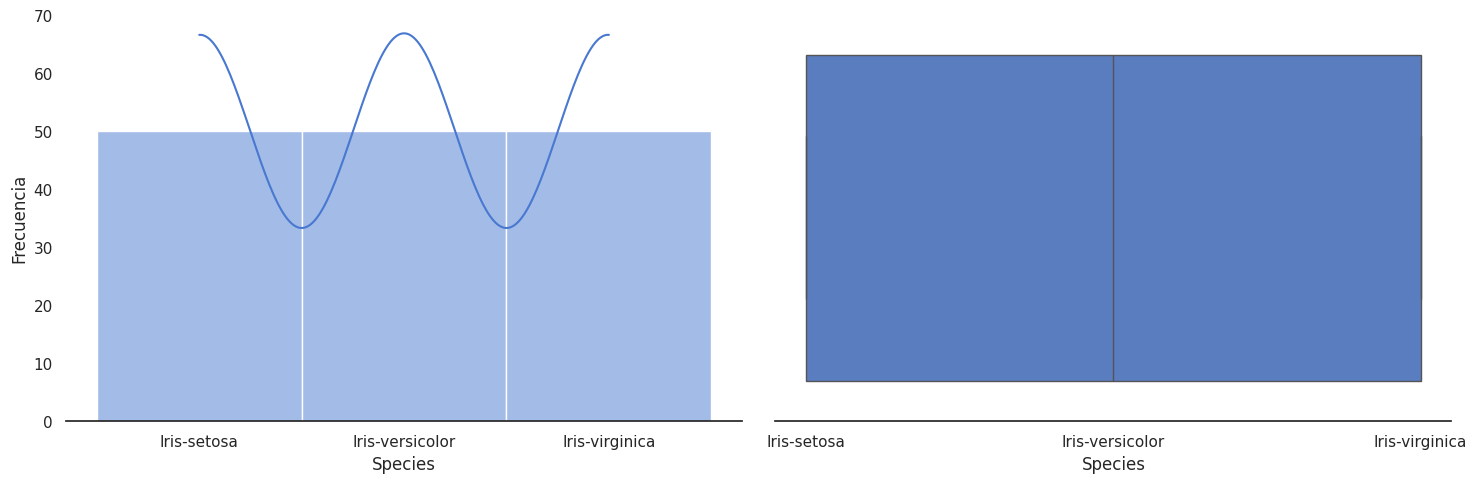

In [9]:
def vis_hist_boxplot(df):
    for i in df.columns:
        fig, ax = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.despine(left=True)

        # Histograma con kde
        sns.histplot(data=df, x=i, kde=True, ax=ax[0]).set_xlabel(f"{i}")
        ax[0].set_ylabel('Frecuencia')
        # Boxplot
        sns.boxplot(data=df, x=i, ax=ax[1])

        plt.tight_layout()
        plt.show()

vis_hist_boxplot(df)

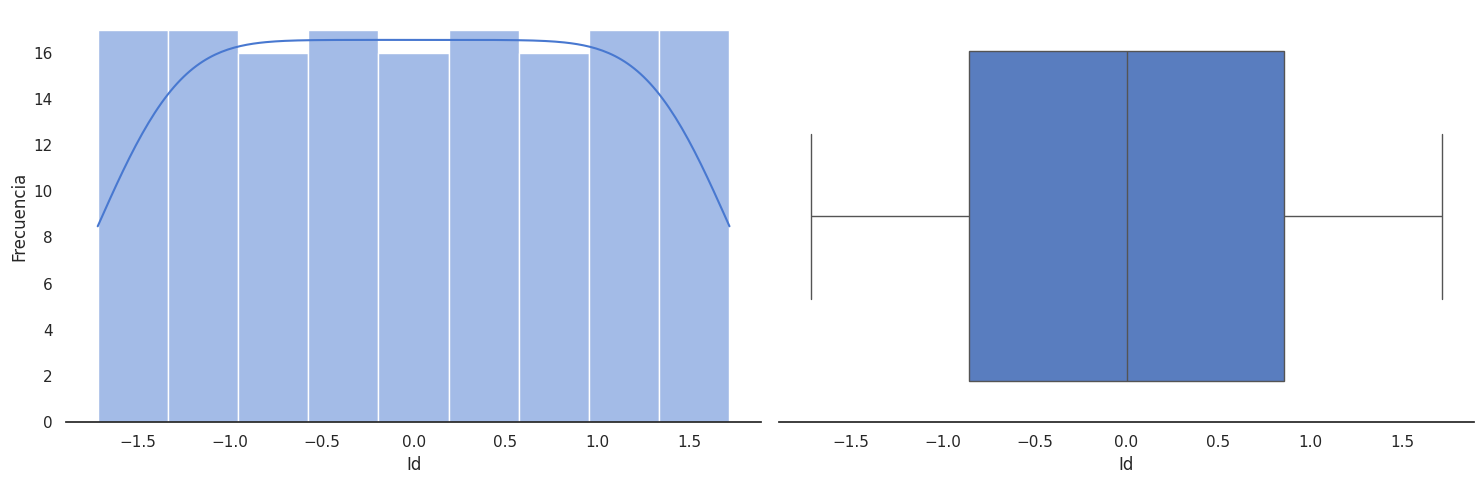

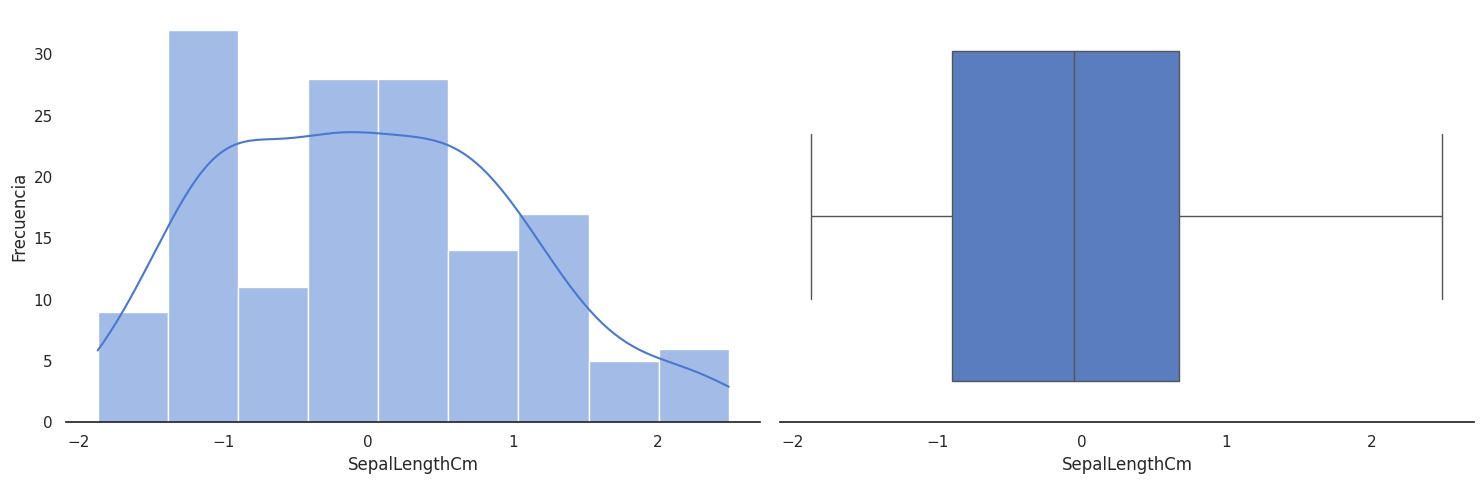

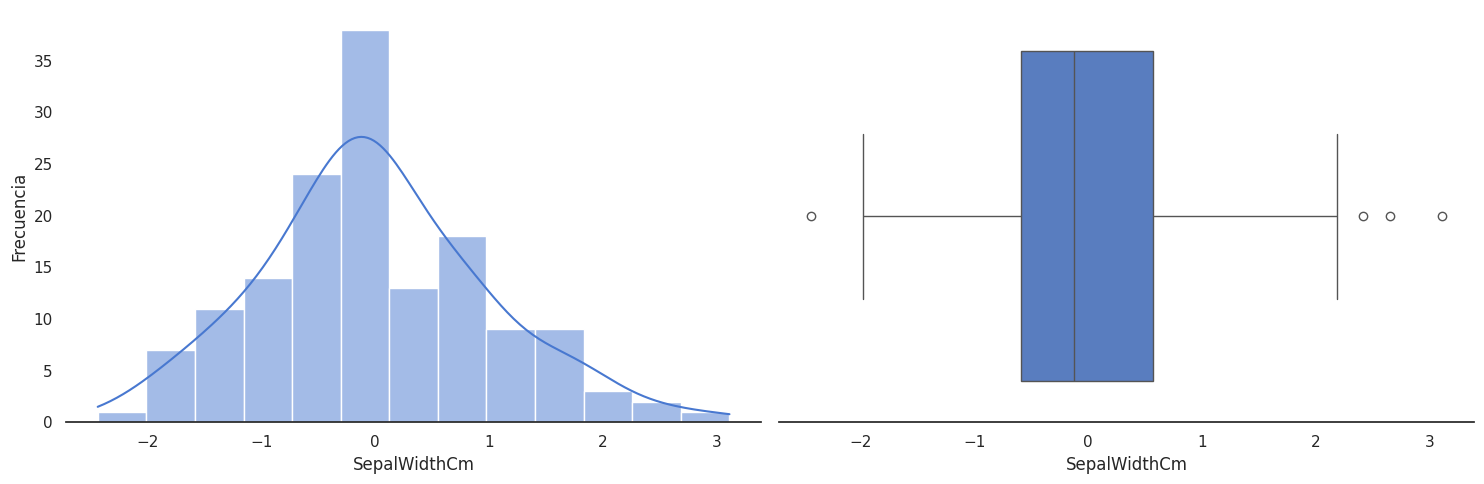

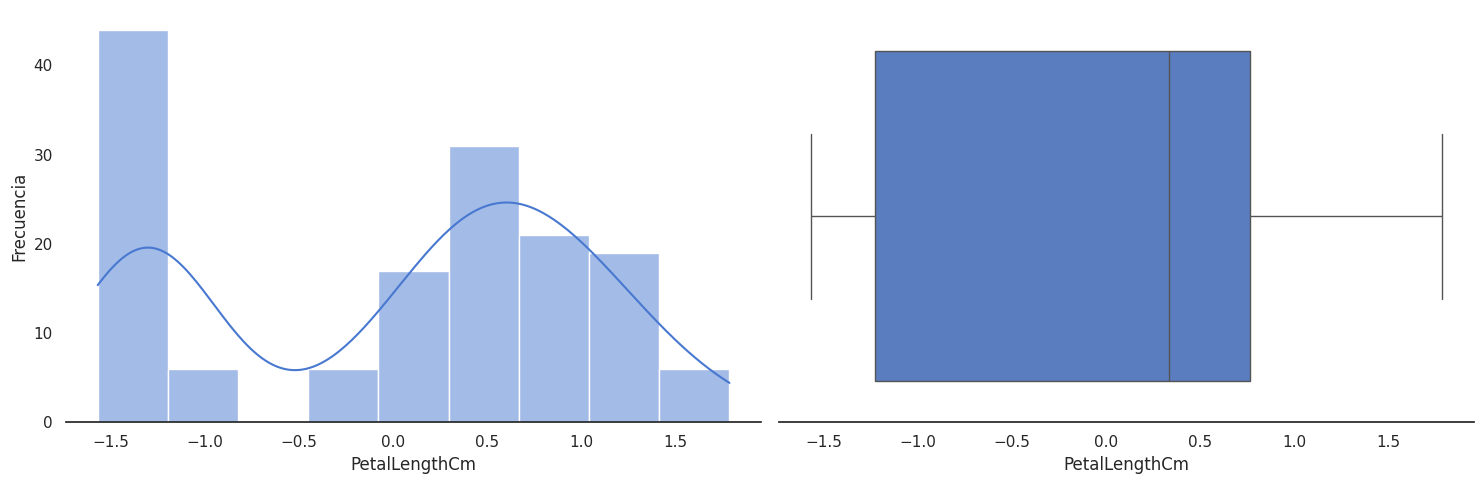

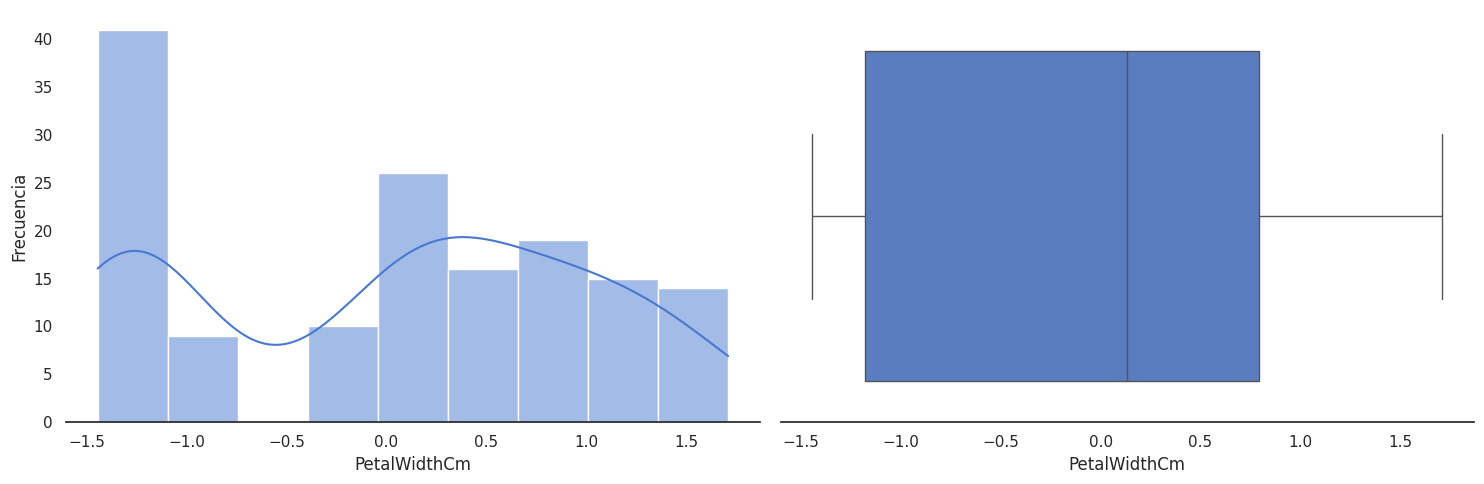

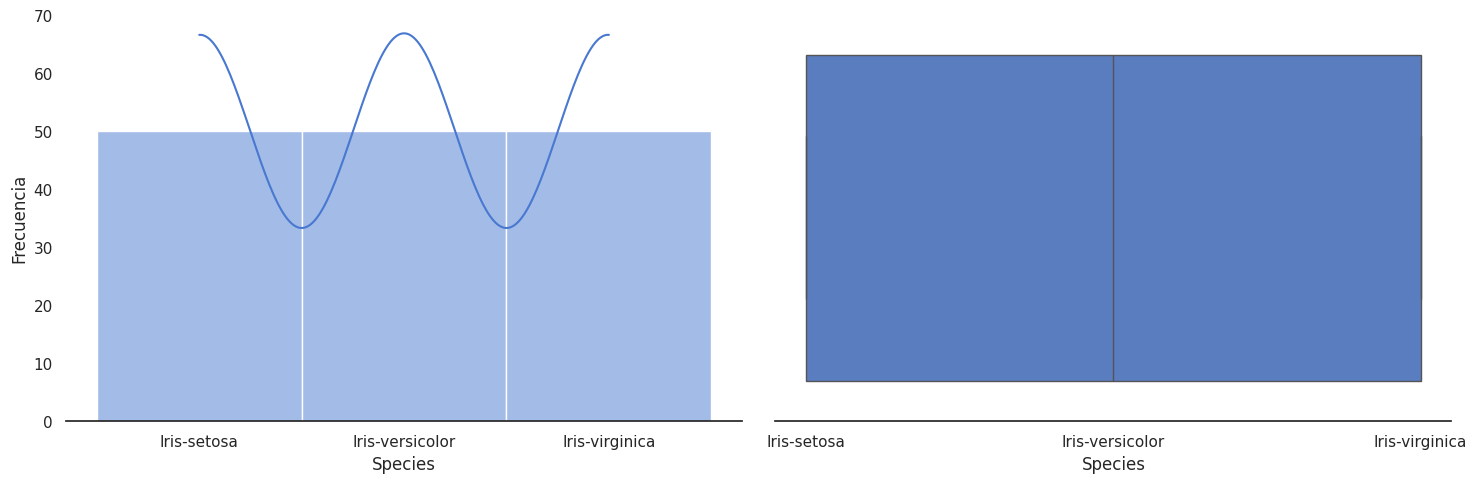

In [10]:
vis_hist_boxplot(df_normalizado)

## Análisis
Se realizó la escalado de los datos en las variables predictoras, y se graficó las ditribuciones de las variables, donde, si bien las variables de Sepal parecen tener distribución que tiende a ser normal, las de Petal tienden a parecer distribuciones asimétricas, y además con un pico más alto y colas más largas comparadas con una curva normal

# 3. Aplicación de PCA:

  – Implementa PCA para reducir las cuatro dimensiones del dataset “Iris” a solo dos componentes principales.
  
  – Calcula la “explained variance” para estos dos componentes y discute qué porcentaje de la variabilidad total de los datos está capturada en el espacio bidimensional.

In [11]:
# Preparar los datos
X = df_normalizado[columnas_a_normalizar]  # Variables normalizadas
y = df['Species']  # Variable objetivo

In [12]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

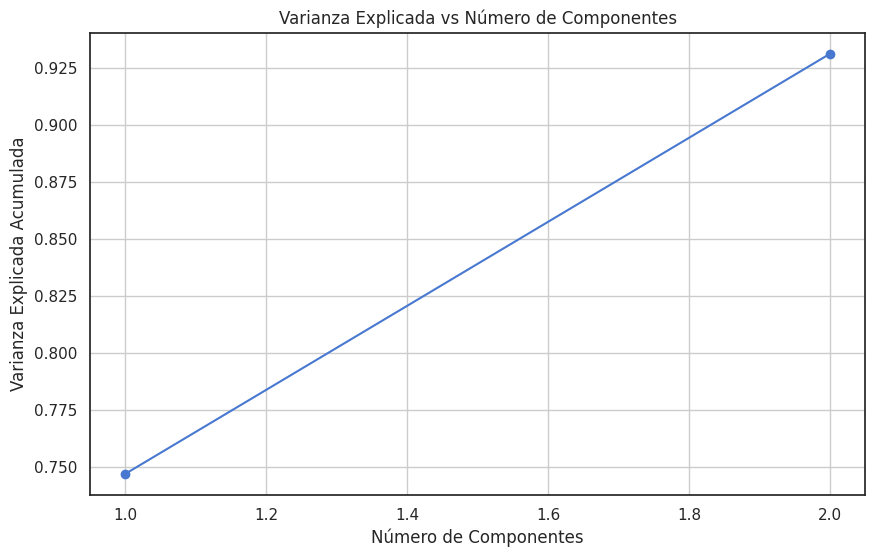

In [24]:
# Calcular varianza acumulada explicada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         varianza_acumulada, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada vs Número de Componentes')
plt.grid(True)
plt.show()

## Análisis
Con dos componentes principales se explica aproximadamente 93% de la varianza.

# 4. Visualización de los componentes principales:

  – Proyecta los datos en el espacio bidimensional formado por los dos primeros componentes principales.
  
  – Utiliza diferentes colores para representar cada una de las tres clases de flores en el gráfico y observa cómo se agrupan las clases en el espacio de los componentes principales.

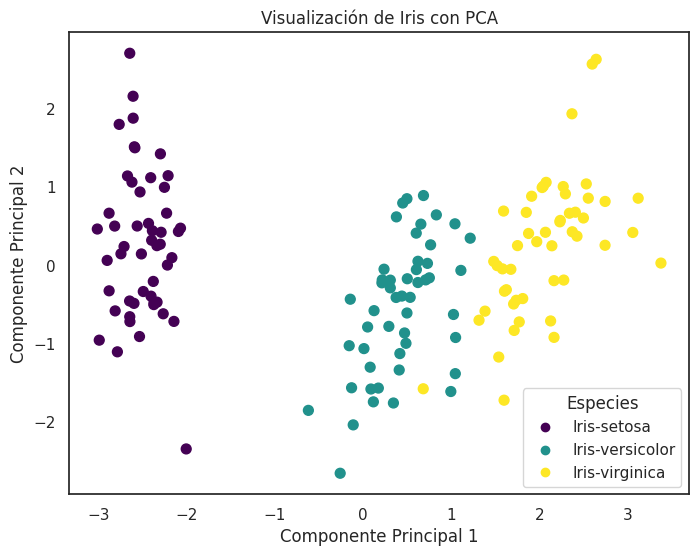

In [25]:
from sklearn.preprocessing import LabelEncoder

# Convertir nombres de especies a etiquetas numéricas
le = LabelEncoder()
y_numeric = le.fit_transform(y)

# Crear el gráfico
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap='viridis', s=50)

# Añadir título y etiquetas
plt.title("Visualización de Iris con PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")

# Crear leyenda con las etiquetas de las especies
handles, labels = scatter.legend_elements()
plt.legend(handles, le.classes_, title="Especies")

# Mostrar gráfico
plt.show()


## Análisis
Si bien se separan las tres Species con estos 2 componentes principales,una especie es notablemente diferente a las otras dos, pero estas restantes no parecen "ajustarse" o conglomerarse o agruparse de forma tal que no haya superposición de puntos y ruido en estos dos Species separadas

# 5. Interpretación de los resultados:

  – Analiza los coeficientes de los dos componentes principales y explica qué variables tienen la mayor influencia en estos.
  
  – Discute si PCA es capaz de separar correctamente las clases y cómo este análisis puede mejorar la comprensión de los datos.

In [26]:
# Crear DataFrame con los coeficientes
coeficientes = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=columnas_a_normalizar
)

# Mostrar las variables más influyentes para los  componentes
print("\nVariables más influyentes en los componentes:")
for i in range(2):
    print(f"\nPC{i+1}:")
    print(coeficientes[f'PC{i+1}'].abs().sort_values(ascending=False).head())


Variables más influyentes en los componentes:

PC1:
PetalLengthCm    0.510792
PetalWidthCm     0.502470
Id               0.481360
SepalLengthCm    0.448450
SepalWidthCm     0.231950
Name: PC1, dtype: float64

PC2:
SepalWidthCm     0.920078
SepalLengthCm    0.382858
PetalWidthCm     0.073568
PetalLengthCm    0.030749
Id               0.022752
Name: PC2, dtype: float64


## Análisis

- Por un lado: La gráfica muestra una clara separación entre las tres especies de Iris utilizando los dos primeros componentes principales. Observándose que:

    - El Componente Principal 1 (eje X) parece ser el más efectivo para separar Iris-setosa (valores negativos) de Iris-versicolor e Iris-virginica (valores positivos)

    - El Componente Principal 2 (eje Y) ayuda principalmente a distinguir entre Iris-versicolor (valores más bajos) e Iris-virginica (valores más altos)

- Por otro lado: Si bien eso se puede apreciar en la gráfica, cuando se revisan las variables más influyentes en los componentes principales, se puede apreciar que al ser solo 5 variables, ambos componentes tienen estaas 5 pero en diferente orden, llamando la atención que, las de Petal tienen un componente principal donde son más influyentes, y a su vez las de Sepal son las mas influyentes en el otro, con Id tengo mis "dudas" porque esto es solo un identificador (150 valores diferentes de 150 valores posibles), por lo que en el modelado puede no ser muy representativo


- En cuanto a la separación de clases PCA demuestra ser muy efectivo en este caso:

    - Iris-setosa está completamente separada de las otras especies (cluster morado a la izquierda)

    - Existe cierto solapamiento entre Iris-versicolor (turquesa) e Iris-virginica (amarillo), lo cual es consistente con el conocimiento biológico de que estas especies son más similares entre sí

# Análisis de Resultados:

  – Compara la distribución de las clases en el espacio bidimensional con la distribución original de las variables. ¿Qué tan bien puede PCA capturar las relaciones entre las clases en este caso?
  
  – Realiza un reporte que incluya el gráfico de los componentes principales y discute la utilidad de PCA para la visualización de datos en problemas de clasificación.

## Análisis

- En cuando a la distribución de las clases en el espacio bidimensional:

    - La reducción a 2 dimensiones mantiene bien la estructura original de los datos
    - La varianza en los datos se captura principalmente en el primer componente principal (separación horizontal)
    - La dispersión vertical (CP2) añade información adicional útil para distinguir entre especies
    - El patrón de agrupamiento sugiere que las características morfológicas originales (longitud y ancho de pétalos y sépalos) están correlacionadas de manera diferente para cada especie

Así, PCA captura de buena manera las relaciones entre las clases de este caso ya que

- Reduce efectivamente la dimensionalidad de 4 variables originales a 2 componentes principales

- Mantiene la estructura esencial de los datos permitiendo una clara visualización de los patrones de agrupamiento

- Facilita la interpretación de las relaciones entre especies

- Proporciona una representación visual intuitiva que podría ser útil para construir un clasificador



# Conclusión:

  – Esta actividad se centra en la visualización de datos utilizando PCA. La reducción de dimensionalidad mediante PCA no solo ayuda a visualizar los datos en un espacio más pequeño, sino que también permite identificar las relaciones entre las variables y las clases.

